# Implementation

In [1]:
include("src/Misc.jl");
include("src/Datasets.jl");
include("src/BayesianCausality.jl");

In [2]:
using .Misc, .BayesianCausality
import .Datasets

In [3]:
using Statistics

import PyPlot, Seaborn 

In [4]:
import Base.Filesystem: mkpath

MARKER = ["o", "v", "d", "X", "p", "*", "P"];

RESULTS_PATH = "./results/abalone"
PARAMS_PATH = "./params"
IMG_PATH = "./img"
N_PARAMS = 36

36

In [5]:
import Random: randperm, seed!

seed!(8457);

## Read Parameters

In [6]:
N_PARAM = 20
params = Dict(Symbol(String(p)) => v for (p,v) ∈ load_json("$PARAMS_PATH/params-$N_PARAM.json"))

γ, M = params[:γ], params[:M]
a₁, b₁, m₁, λ₁ = params[:a₁], params[:b₁], params[:m₁], params[:λ₁]
a₂, b₂, m₂, λ₂ = params[:a₂], params[:b₂], params[:m₂], params[:λ₂]

(1.0, 1.0, 0.0, 0.1)

In [7]:
causal_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₂, 
                     :a₁=>a₁, :a₂=>a₂, :b₁=>b₁, :b₂=>b₂);
spurious_params = Dict(:γ=>γ, :m₁=>m₁, :m₂=>m₂, :λ₁=>λ₁, :λ₂=>λ₁, 
                       :a₁=>a₁, :a₂=>a₁, :b₁=>b₁, :b₂=>b₁);

hyper_params = causal_params;

In [8]:
EPOCHS = 100

100

## Read Data

In [9]:
valid_pairs = setdiff([1,43,44,45,46,76,87,19,91,92],[52,53,54,55,71])
tuebingen_data = Datasets.tuebingen(valid_pairs);

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


In [10]:
R = fill(5,length(valid_pairs))

10-element Array{Int64,1}:
 5
 5
 5
 5
 5
 5
 5
 5
 5
 5

## Dual EM

In [11]:
r_EM = []
for p ∈ 1:length(valid_pairs)
    X₁, X₂ = tuebingen_data[p][:X], tuebingen_data[p][:Y]

    x = (X₁ .- mean(X₁)) ./ std(X₁)
    y = (X₂ .- mean(X₂)) ./ std(X₂)

    X = '>' ∈ tuebingen_data[p][:relationship] ? [x y] : [y x]
    append!(r_EM, [dual_em(X, R[p]; EPOCHS=EPOCHS, M=M, hyper_params...)])
end

In [12]:
save_json("$RESULTS_PATH/dual_em.json", r=r_EM);

## Results

In [13]:
import Seaborn

In [14]:
function plot_pair(pair::Dict{Symbol,Any}, r_EM, R=1; ax=PyPlot.gca(), normalize=false, kwargs...)
    X, Y = pair[:X], pair[:Y]
    Xⁿ = normalize ? (X .- mean(X)) / std(X) : X
    Yⁿ = normalize ? (Y .- mean(Y)) / std(Y) : Y
    for r ∈ 1:R
        ax.scatter(Xⁿ[r_EM .== r], Yⁿ[r_EM .== r]; marker=".", label="\$r_1=$(r)\$", kwargs...)
    end
    #ax.set_title("$(pair[:id]): $(pair[:dataset])")
    ax.set_title("$(pair[:id])")
    ax.set_xlabel("X: $(pair[:X_label])")
    ax.set_ylabel("Y: $(pair[:Y_label])")
    ax.legend()
end

plot_pair (generic function with 2 methods)

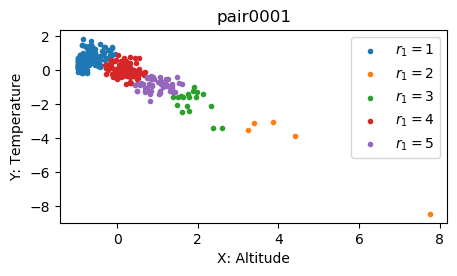

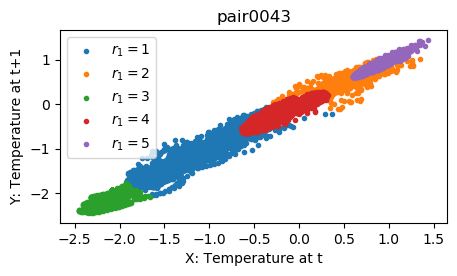

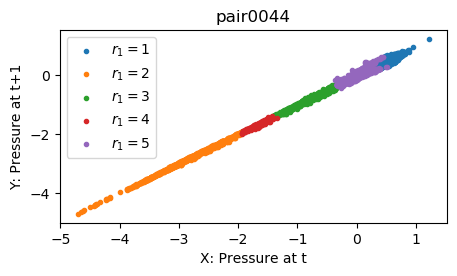

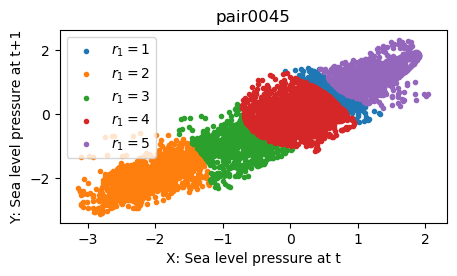

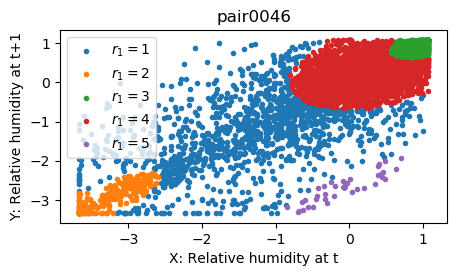

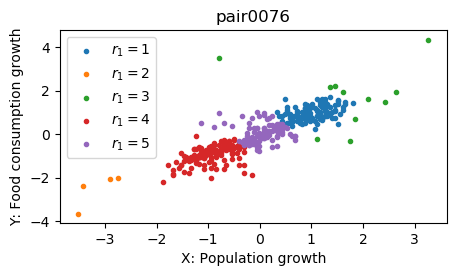

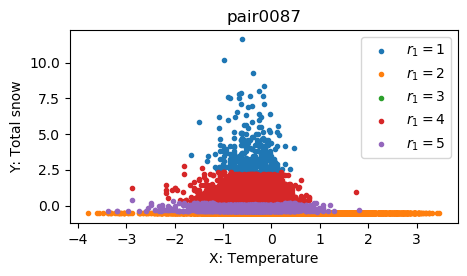

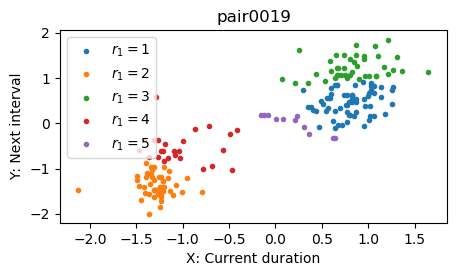

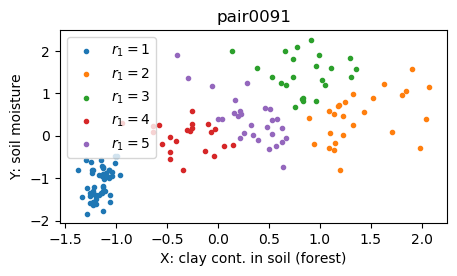

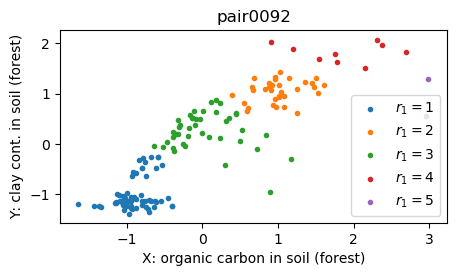

In [15]:
for p ∈ 1:length(valid_pairs)
    fig = PyPlot.figure(figsize=(5,2.5))
    plot_pair(tuebingen_data[p], r_EM[p], R[p], normalize=true)
    PyPlot.savefig("./img/$(tuebingen_data[p][:id])_DEM.pdf", bbox_inches="tight");
end